In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
from lowEBMs.Packages.Variables import Vars,reset, trackerreset, datareset
from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs import update_plotstyle, moving_average
import lowEBMs.Packages.Constants as const

import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
time_HADCM3_str=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[0],delimiter=',',skip_header=1,dtype='str',unpack=True,encoding='ISO-8859-1')
time_HADCM3=np.zeros(len(time_HADCM3_str))
for i in range(len(time_HADCM3_str)):
    if time_HADCM3_str[i][-4]=='.':
        year=float(time_HADCM3_str[i][-3:])
    if time_HADCM3_str[i][-5]=='.':
        year=float(time_HADCM3_str[i][-4:])
    if time_HADCM3_str[i][4]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    if time_HADCM3_str[i][5]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    day=float(time_HADCM3_str[i][:2])/365
    time_HADCM3[i]=year+month+day
GMT_HADCM3=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[17],delimiter=',',skip_header=1,unpack=True,encoding='ISO-8859-1')
order=np.argsort(time_HADCM3)
GMT_HADCM3_smoothed=moving_average(GMT_HADCM3[order],12)

In [2]:
Year_volc, CWL_GMT,  EVA_GMT, CWLcorr_GMT=np.genfromtxt('Data/Volc_800_2000.txt',skip_header=1,unpack=True)
Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)
#Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
#np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)

In [3]:
Year_volc_1800_1850=Year_volc[int(1000*365/4):int(1040*365/4)]
Year_volc_1808_1858=Year_volc[int(1008*365/4):int(1048*365/4)]
EVA_GMT_1800_1850=EVA_GMT[int(1000*365/4):int(1040*365/4)]
EVA_GMT_1808_1858=EVA_GMT[int(1008*365/4):int(1048*365/4)]
NORESM_1990_2005=SAT_VOLC-SAT_TREN

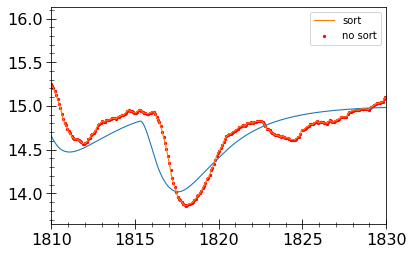

In [5]:
#print(time_HADCM3)
#print(GMT_HADCM3)
plt.plot(Year_volc,CWL_GMT+15)
plt.scatter(time_HADCM3,moving_average(GMT_HADCM3,12),s=5,c='r',label='no sort')
plt.plot(time_HADCM3[order],moving_average(GMT_HADCM3[order],12),label='sort')
#plt.plot(time_HADCM3,moving_average(GMT_HADCM3,12),label='sort')
plt.xlim(1810,1830)
plt.legend()
#plt.savefig('HADCM3-data.png',format='PNG')

In [4]:
def coremodule(config,P0,P_pert_ratio,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            P_pert=(Pmax-Pmin)*P_pert_ratio
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert_ratio

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['rk4input'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        dataZMT=data[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        data_out=dataZMT
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        dataZMT=data_CTRL[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        dataGMT=np.transpose(data[2][:-1]-data[2][0])
        data_out=[dataZMT,dataGMT]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [9]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b']]
#labels=[['eqparam','c_ao'],['func1','k'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P0=np.array([70*4.2e6,230,2.5])
#P0=np.array([70*4.2e6,1,0.5,1.9e-15,1.165,1.165,1.165])
P0=np.array([70*4.2e6,230,2.5,1.165,1.165,1.165])
Pmin=np.array([1*4.2e6,190,1.9,0.9,0.9,0.9])
Pmax=np.array([150*4.2e6,250,3.3,1.3,1.3,1.3])
#Pmin=np.array([1*4.2e6,0.9,0.4,0.5e-15,0.9,0.9,0.9])
#Pmax=np.array([150*4.2e6,1.1,0.6,5e-15,1.3,1.3,1.3])
P_pert_ratio=1/10000
#Pmin=np.array([20*4.2e6,190,1.7])
#Pmax=np.array([120*4.2e6,250,3.3])
#P_pert=(Pmax-Pmin)/100
precision=1e-6
maxlength=int(40)
targetmode='GMT'
target=NORESM_1990_2005#EVA_GMT_1808_1858
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.5
num_params=6
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Volcanic_Budyko_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        
config_base=importer('Dev_Data/Optimization/Volcanic_Budyko.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Budyko_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Volcanic_Budyko.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[0.3882516  0.38811532 0.38838803 0.3882516  0.3882516  0.38816703
 0.38833619 0.3882516  0.3882516  0.3882516  0.3882516  0.3882516
 0.3882516 ]
1e-08
[2.94000018e+08 2.30000000e+02 2.50000003e+00 1.16500000e+00
 1.16500000e+00 1.16500000e+00]
Iteration no.1


[0.38825154 0.38811526 0.38838797 0.38825154 0.38825154 0.38816697
 0.38833614 0.38825154 0.38825154 0.38825154 0.38825154 0.38825154
 0.38825154]
0.03306484388980251
[3.54927280e+08 2.30000003e+02 2.59135831e+00 1.16500000e+00
 1.16500000e+00 1.16500000e+00]
Iteration no.2


[0.2667304  0.2666999  0.26676096 0.26673039 0.2667304  0.26667036
 0.26679045 0.2667304  0.2667304  0.2667304  0.2667304  0.2667304
 0.2667304 ]
0.04682024668059389
[3.74245103e+08 2.30000264e+02 2.68319014e+00 1.16500001e+00
 1.16500000e+00 1.16500004e+00]
Iteration no.3


[0.22577581 0.22576931 0.22578236 0.2257758  0.22577582 0.22572754
 0.2258241  0.22577581 0.22577581 0.22577581 0.22577581 0.22577581
 0.22577581]
0.09882177508048028
[3.82955655e+08 2.30001451e+02 2.83904418e+00 1.16500005e+00
 1.16500002e+00 1.16500022e+00]
Iteration no.4


[0.17989325 0.17990059 0.17988596 0.17989323 0.17989326 0.17985841
 0.1799281  0.17989325 0.17989325 0.17989325 0.17989325 0.17989325
 0.17989325]
0.20823645985384326
[3.62368335e+08 2.30004169e+02 3.07609339e+00 1.16500013e+00
 1.16500005e+00 1.16500062e+00]
Iteration no.5


[0.13183104 0.13182951 0.13183262 0.13183103 0.13183105 0.13180991
 0.13185217 0.13183104 0.13183104 0.13183104 0.13183104 0.13183104
 0.13183104]
0.4347811722472313
[3.71512193e+08 2.30007250e+02 3.30000000e+00 1.16500022e+00
 1.16500009e+00 1.16500102e+00]
Iteration no.6


[3.08887579 3.08965554 3.08809799 3.08768888 3.09006594 3.08812737
 3.08962569 3.08886071 3.08889087 3.08887047 3.08888112 3.08881292
 3.08893867]
0.0027729595466423804
[3.42329397e+08 2.32973416e+02 3.30000000e+00 1.16525272e+00
 1.16508923e+00 1.16605373e+00]
Iteration no.7


[1.51313436 1.5128927  1.51337631 1.51307379 1.51319516 1.51281041
 1.51345852 1.51313235 1.51313637 1.51313374 1.51313498 1.5131259
 1.51314281]
0.0021427597246300644
[3.49331152e+08 2.33090452e+02 3.30000000e+00 1.16527872e+00
 1.16509725e+00 1.16616310e+00]
Iteration no.8


[1.48645385 1.48624268 1.48666532 1.48638109 1.48652689 1.4861401
 1.48676784 1.48645178 1.48645592 1.4864532  1.4864545  1.48644513
 1.48646257]
0.0133878581214517
[3.87563175e+08 2.33968839e+02 3.30000000e+00 1.16544610e+00
 1.16514951e+00 1.16686780e+00]
Iteration no.9


[1.24868975 1.24873147 1.24864841 1.24023413 1.25698185 1.25868386
 1.23842737 1.24867165 1.24870785 1.24868192 1.24869758 1.24862153
 1.24875795]
1.990648954189367e-05
[3.87552003e+08 2.34118864e+02 3.29341382e+00 1.16544827e+00
 1.16515045e+00 1.16687599e+00]
Iteration no.10


[0.83167019 0.83163437 0.83170622 0.83145684 0.83188863 0.83170426
 0.83164317 0.83166882 0.83167155 0.83166973 0.83167065 0.83166426
 0.83167612]
2.006548386440299e-05
[3.87561744e+08 2.34122763e+02 3.29339380e+00 1.16544844e+00
 1.16515051e+00 1.16687671e+00]
Iteration no.11


[0.83152148 0.83148529 0.83155787 0.83131203 0.83173582 0.83155074
 0.831499   0.83152012 0.83152283 0.83152102 0.83152193 0.83151559
 0.83152737]
0.0003425404399433839
[3.87729708e+08 2.34188088e+02 3.29310436e+00 1.16545125e+00
 1.16515145e+00 1.16688890e+00]
Iteration no.12


[0.82940793 0.82936686 0.82944921 0.82924616 0.82957259 0.8293793
 0.8294404  0.8294067  0.82940917 0.82940753 0.82940834 0.82940251
 0.82941336]
0.0004562812959979922
[3.87983595e+08 2.34255114e+02 3.29355970e+00 1.16545465e+00
 1.16515257e+00 1.16690384e+00]
Iteration no.13


[0.82738224 0.82733919 0.82742549 0.82723804 0.82752872 0.82733332
 0.82743413 0.82738105 0.82738343 0.82738186 0.82738263 0.82737701
 0.82738748]
0.00045665641295419135
[3.88249868e+08 2.34314847e+02 3.29431161e+00 1.16545793e+00
 1.16515363e+00 1.16691827e+00]
Iteration no.14


[0.82549361 0.82544985 0.82553755 0.82535659 0.82563268 0.82543692
 0.82555296 0.82549244 0.82549477 0.82549323 0.82549398 0.82548846
 0.82549875]
0.00016267307443034462
[3.88346263e+08 2.34335057e+02 3.29461994e+00 1.16545908e+00
 1.16515400e+00 1.16692332e+00]
Iteration no.15


[0.82483344 0.8247896  0.82487748 0.82469785 0.82497108 0.82477536
 0.82489414 0.82483228 0.8248346  0.82483307 0.82483381 0.82482832
 0.82483857]
8.91224322621616e-05
[3.88399186e+08 2.34346015e+02 3.29479285e+00 1.16545970e+00
 1.16515420e+00 1.16692607e+00]
Iteration no.16


[0.82447327 0.82442939 0.82451734 0.82433834 0.82461022 0.82441455
 0.82453458 0.82447211 0.82447443 0.82447289 0.82447364 0.82446815
 0.82447838]
4.597574032035188e-05
[3.88426508e+08 2.34351640e+02 3.29488299e+00 1.16546002e+00
 1.16515430e+00 1.16692749e+00]
Iteration no.17


[0.82428785 0.82424395 0.82433193 0.82415322 0.82442447 0.82422883
 0.82434944 0.82428669 0.82428901 0.82428747 0.82428822 0.82428274
 0.82429296]
2.064528549127134e-05
[3.88438780e+08 2.34354160e+02 3.29492366e+00 1.16546017e+00
 1.16515435e+00 1.16692813e+00]
Iteration no.18


[0.82420466 0.82416076 0.82424874 0.82407018 0.82434114 0.82414552
 0.82426638 0.82420351 0.82420582 0.82420429 0.82420504 0.82419956
 0.82420977]
0.00028518788129511165
[3.88608315e+08 2.34388934e+02 3.29548664e+00 1.16546216e+00
 1.16515499e+00 1.16693693e+00]
Iteration no.19


[0.823058   0.82301403 0.82310214 0.82292534 0.82319261 0.82299716
 0.82312134 0.82305685 0.82305915 0.82305763 0.82305837 0.82305292
 0.82306308]
5.757264365336878e-05
[3.88642591e+08 2.34395858e+02 3.29560341e+00 1.16546256e+00
 1.16515512e+00 1.16693870e+00]
Iteration no.20


[0.82282769 0.82278371 0.82287184 0.8226953  0.822962   0.82276661
 0.82289125 0.82282654 0.82282884 0.82282732 0.82282806 0.82282261
 0.82283276]
0.000635103389395047
[3.89020792e+08 2.34472080e+02 3.29689635e+00 1.16546696e+00
 1.16515654e+00 1.16695816e+00]
Iteration no.21


[0.82029713 0.82025316 0.82034128 0.82016773 0.8204284  0.82023358
 0.82036309 0.820296   0.82029827 0.82029677 0.8202975  0.82029211
 0.82030216]
0.0009720160661558672
[3.89599516e+08 2.34586100e+02 3.29895242e+00 1.16547364e+00
 1.16515868e+00 1.16698766e+00]
Iteration no.22


[0.81647331 0.81642964 0.81651715 0.81634642 0.81660202 0.81640834
 0.8165406  0.81647218 0.81647443 0.81647295 0.81647367 0.81646833
 0.81647828]
0.012385081079442532
[3.96922813e+08 2.36010653e+02 3.30000000e+00 1.16555778e+00
 1.16518562e+00 1.16735950e+00]
Iteration no.23


[0.60699026 0.60701174 0.60696888 0.59894797 0.61494756 0.61706069
 0.59677241 0.60697258 0.60700794 0.60698315 0.60699737 0.60690943
 0.60707109]
3.69128751833663e-05
[3.96912124e+08 2.36276418e+02 3.28776799e+00 1.16556172e+00
 1.16518721e+00 1.16737751e+00]
Iteration no.24


[0.25023194 0.25024003 0.2502239  0.25022927 0.25023465 0.25018278
 0.25028116 0.25023189 0.25023199 0.25023193 0.25023195 0.2502317
 0.25023218]
3.6773419737858696e-05
[3.96908116e+08 2.36276507e+02 3.28782708e+00 1.16556173e+00
 1.16518721e+00 1.16737756e+00]
Iteration no.25


[0.25021063 0.25021872 0.25020258 0.25020794 0.25021335 0.25016149
 0.25025982 0.25021058 0.25021067 0.25021061 0.25021064 0.25021039
 0.25021086]
0.06639258028056298
[3.89668761e+08 2.36438165e+02 3.30000000e+00 1.16558108e+00
 1.16519234e+00 1.16747233e+00]
Iteration no.26


[0.2453312  0.24533576 0.24532668 0.24531855 0.24534478 0.24529596
 0.24536792 0.24533112 0.24533127 0.24533117 0.24533122 0.24533085
 0.24533154]
0.025120659470823772
[3.88128966e+08 2.36734649e+02 3.30000000e+00 1.16559200e+00
 1.16519573e+00 1.16752472e+00]
Iteration no.27


[0.24498889 0.24499142 0.24498641 0.24498657 0.24499125 0.2449396
 0.24503825 0.24498884 0.24498893 0.24498888 0.2449889  0.24498866
 0.24498911]
0.007255642401637953
[3.87883382e+08 2.36749898e+02 3.30000000e+00 1.16559401e+00
 1.16519625e+00 1.16753462e+00]
Iteration no.28


[0.24497364 0.24497597 0.24497136 0.24497146 0.24497586 0.24492417
 0.24502319 0.2449736  0.24497369 0.24497363 0.24497365 0.24497342
 0.24497387]
0.05332211289433255
[3.86225099e+08 2.36855377e+02 3.30000000e+00 1.16560867e+00
 1.16520004e+00 1.16760689e+00]
Iteration no.29


[0.2448983  0.24489927 0.24489737 0.24489681 0.24489981 0.24484783
 0.24494881 0.24489825 0.24489834 0.24489829 0.24489831 0.24489808
 0.24489851]
0.0645165150973687
[3.85400576e+08 2.36942545e+02 3.30000000e+00 1.16562566e+00
 1.16520431e+00 1.16769099e+00]
Iteration no.30


[0.24487067 0.24487095 0.24487044 0.24486951 0.24487185 0.24481974
 0.24492164 0.24487063 0.24487072 0.24487066 0.24487068 0.24487046
 0.24487089]
0.07391707061189276
[3.85145274e+08 2.37020336e+02 3.30000000e+00 1.16564470e+00
 1.16520905e+00 1.16778547e+00]
Iteration no.31


[0.24485573 0.24485577 0.24485574 0.24485476 0.24485672 0.24480456
 0.24490693 0.24485569 0.24485578 0.24485572 0.24485574 0.24485552
 0.24485594]
0.08935355202396633
[3.85128750e+08 2.37099134e+02 3.30000000e+00 1.16566742e+00
 1.16521465e+00 1.16789833e+00]
Iteration no.32


[0.24484319 0.24484318 0.24484326 0.24484235 0.24484404 0.24479187
 0.24489454 0.24484315 0.24484323 0.24484318 0.2448432  0.24484299
 0.2448434 ]
0.15982219676718035
[3.85217001e+08 2.37220340e+02 3.30000000e+00 1.16570764e+00
 1.16522452e+00 1.16809837e+00]
Iteration no.33


[0.24482669 0.24482669 0.24482675 0.24482601 0.24482739 0.24477523
 0.24487818 0.24482665 0.24482674 0.24482668 0.2448267  0.24482649
 0.2448269 ]
0.27639828910013525
[3.85325088e+08 2.37391409e+02 3.30000000e+00 1.16577638e+00
 1.16524127e+00 1.16844057e+00]
Iteration no.34


[0.24480757 0.24480758 0.2448076  0.24480704 0.24480811 0.24475596
 0.24485919 0.24480753 0.24480761 0.24480756 0.24480758 0.24480737
 0.24480777]
0.42485361561104856
[3.85381798e+08 2.37595517e+02 3.30000000e+00 1.16588071e+00
 1.16526654e+00 1.16896064e+00]
Iteration no.35


[0.24474452 0.24474596 0.24474311 0.24459044 0.24478936 0.24473723
 0.24458265 0.24474425 0.24474479 0.24474442 0.24474462 0.2447433
 0.24474573]
0.00045031844946887716
[3.85373138e+08 2.37635827e+02 3.29886304e+00 1.16588145e+00
 1.16526682e+00 1.16896395e+00]
Iteration no.36


[0.23769013 0.23769846 0.23768183 0.23705881 0.2383044  0.23843777
 0.23691301 0.23768884 0.23769141 0.2376896  0.23769065 0.23768438
 0.23769587]
5.756403022246362e-05
[3.85366667e+08 2.37668092e+02 3.29742944e+00 1.16588189e+00
 1.16526700e+00 1.16896595e+00]
Iteration no.37


[0.22395661 0.22396855 0.2239447  0.22307857 0.22482513 0.22504175
 0.22285455 0.22395483 0.22395839 0.22395588 0.22395733 0.22394867
 0.22396454]
0.00013452949071863138
[3.85344989e+08 2.37773826e+02 3.29262347e+00 1.16588334e+00
 1.16526759e+00 1.16897239e+00]
Iteration no.38


[0.15651815 0.15653193 0.15650441 0.15538605 0.15766366 0.15799182
 0.15506641 0.15651587 0.15652042 0.15651721 0.15651908 0.15650802
 0.15652827]
0.0004063287430810047
[3.85269422e+08 2.38190284e+02 3.27320841e+00 1.16588892e+00
 1.16526989e+00 1.16899724e+00]
Iteration no.39


[1.00000000e-08 3.30648439e-02 4.68202467e-02 9.88217751e-02
 2.08236460e-01 4.34781172e-01 2.77295955e-03 2.14275972e-03
 1.33878581e-02 1.99064895e-05 2.00654839e-05 3.42540440e-04
 4.56281296e-04 4.56656413e-04 1.62673074e-04 8.91224323e-05
 4.59757403e-05 2.06452855e-05 2.85187881e-04 5.75726437e-05
 6.35103389e-04 9.72016066e-04 1.23850811e-02 3.69128752e-05
 3.67734197e-05 6.63925803e-02 2.51206595e-02 7.25564240e-03
 5.33221129e-02 6.45165151e-02 7.39170706e-02 8.93535520e-02
 1.59822197e-01 2.76398289e-01 4.24853616e-01 4.50318449e-04
 5.75640302e-05 1.34529491e-04 4.06328743e-04 4.03956576e-04]


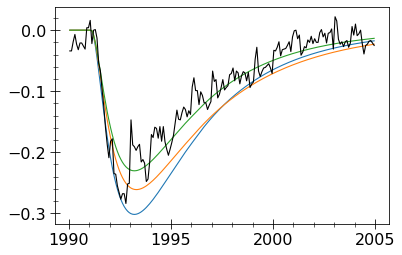

In [11]:
for i in [0,2,-1]:
    plt.plot(Year_NorESM,data[i,0],label=i)
#plt.plot(Year_volc_1808_1858,data[1,1])
#plt.plot(Year_volc_1808_1858,data[1,2])
#plt.plot(Year_volc_1808_1858,data[1,3])
#plt.plot(Year_volc_1808_1858,data[1,4])
plt.plot(Year_NorESM,NORESM_1990_2005,c='k')
#plt.legend()
#plt.xlim(1808,1858)
print(gamma)

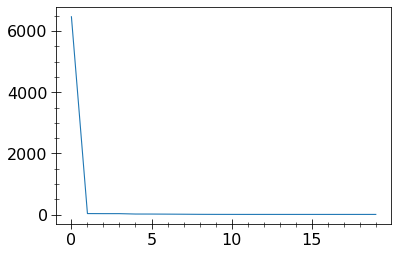

In [18]:
plt.plot(np.arange(20),F[:,0])

In [22]:
labels=[['eqparam','c_ao'],['func1','k'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P_optimal=[2.95884187e+08, 5.30172001e-01, 4.67588394e-15, 1.16595323e+00, 1.16530232e+00, 1.16991354e+00]
#P_optimal=[3.61776874e+08, 9.87995931e-01, 5.04740356e-01, 5.00000000e-15, 1.16572428e+00, 1.16530753e+00, 1.16942513e+00]
P_optimal=[3.70805207e+08, 9.80888475e-01, 4.84576966e-01, 5.00000000e-15, 1.17020016e+00, 1.16742730e+00, 1.19984391e+00]
config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini')
variable_importer(config_CTRL)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config_CTRL=add_parameters(config_CTRL,P_optimal,labels)
data_CTRL=rk4alg(model_equation,config_CTRL['eqparam'],config_CTRL['rk4input'],config_CTRL['funccomp'],progressbar=True)

config_base=importer('Dev_Data/Optimization/Volcanic_Sellers.ini')
variable_importer(config_base)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config_base=add_parameters(config_base,P_optimal,labels)
elevation=-0.0065*np.array(ParasCTRL[1][1])
#P_config=reshape_parameters(P0,P_pert)

#print(config)
Vars.T,Vars.T_global=data_CTRL[1][-1],data_CTRL[2][-1]
data=rk4alg(model_equation,config_base['eqparam'],config_base['rk4input'],config_base['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini



Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


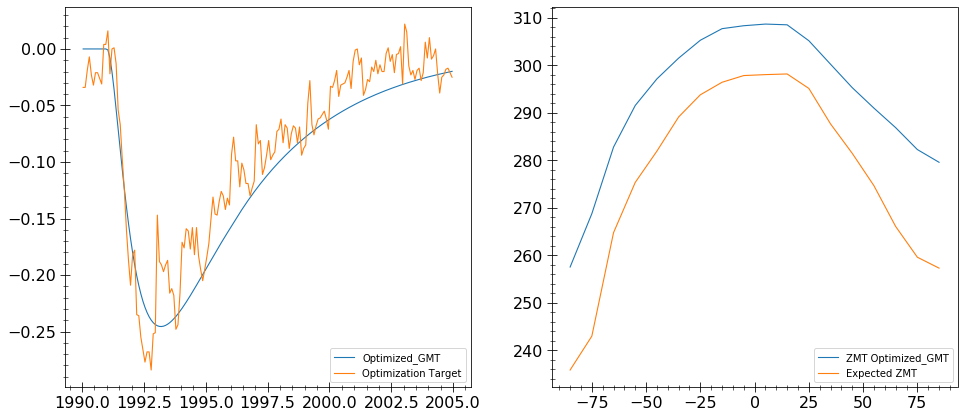

In [27]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')
Lat_ERA,ZMT_ERA=np.loadtxt('Data/ERA_ZMT_Mean.txt')
#plt.plot(Vars.Lat,data[1][-1]+elevation)
#plt.plot(Lat_10,ZMT_10)
ax[0].plot(Year_NorESM,data[2][1:]-data[2][0],label='Optimized_GMT')
ax[0].plot(Year_NorESM,NORESM_1990_2005,label='Optimization Target')
ax[0].legend(loc='lower right')

ax[1].plot(Vars.Lat,data[1][0]+elevation,label='ZMT Optimized_GMT')
ax[1].plot(Lat_10,ZMT_10,label='Expected ZMT')
ax[1].legend(loc='lower right')
plt.savefig('GMT_Optimization_Comparison.eps',format='EPS',bbox_inches='tight')

In [12]:
plt.plot(Vars.Lat,data[1][0]+elevation)
plt.plot(Lat_10,ZMT_10)

ValueError: operands could not be broadcast together with shapes (180,) (18,) 

In [ ]:
2.95884187e+08 5.30172001e-01 4.67588394e-15 1.16595323e+00
 1.16530232e+00 1.16991354e+00

In [28]:
3.70805207e+08/4.2e6

88.28695404761905